**Getting the data:**
First, let's fetch the cats vs. dogs dataset using TFDS. Tansfer learning is most useful when working with very small datases. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete3BH2JE/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all different sizes. We can also see that label 1 is "dog" and label 0 is "cat".

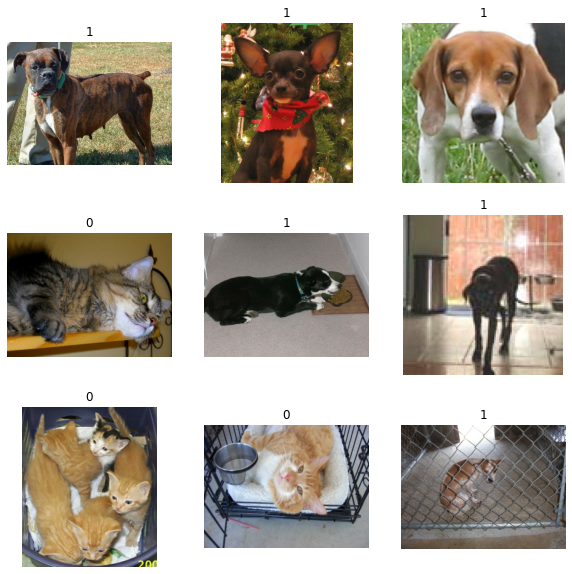

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

**Standardizing the data:** Our raw images have a variety of sizes. This isn't a great fit for feeding a neural network. Standardize to a fixed image size. We pick 150x150.

In [3]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [4]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

**Using random data augmentation:** When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the first image of the first batch looks like after various random transformations:

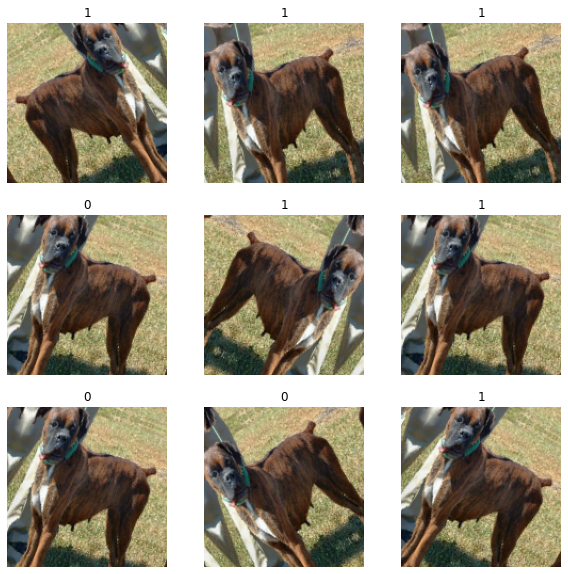

In [6]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Build a model:**

In [7]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained ResNet50 weights requires that input be normalized
x = keras.applications.resnet50.preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0      

**Train the top layer**

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 64s 170ms/step - loss: 0.1640 - binary_accuracy: 0.9267 - val_loss: 0.0623 - val_binary_accuracy: 0.9794
Epoch 2/10
291/291 [==============================] - 47s 161ms/step - loss: 0.1044 - binary_accuracy: 0.9586 - val_loss: 0.0547 - val_binary_accuracy: 0.9789
Epoch 3/10
291/291 [==============================] - 47s 162ms/step - loss: 0.0896 - binary_accuracy: 0.9635 - val_loss: 0.0656 - val_binary_accuracy: 0.9802
Epoch 4/10
291/291 [==============================] - 47s 162ms/step - loss: 0.0823 - binary_accuracy: 0.9678 - val_loss: 0.0808 - val_binary_accuracy: 0.9729
Epoch 5/10
291/291 [==============================] - 47s 163ms/step - loss: 0.0775 - binary_accuracy: 0.9680 - val_loss: 0.0676 - val_binary_accuracy: 0.9789
Epoch 6/10
291/291 [==============================] - 47s 161ms/step - loss: 0.0823 - binary_accuracy: 0.9673 - val_loss: 0.0541 - val_binary_accuracy: 0.9811
Epoch 7/10
291/291 [==========================

**Evaluation on the test set:**

In [9]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
73/73 [==============================] - 9s 118ms/step - loss: 0.0737 - binary_accuracy: 0.9781
test loss, test acc: [0.07370615005493164, 0.9780739545822144]


**Fine-tuning**

In [10]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
73/73 [==============================] - 9s 119ms/step - loss: 0.0863 - binary_accuracy: 0.9794
test loss, test acc: [0.08627454191446304, 0.979363739490509]
